<a href="https://colab.research.google.com/github/Maozheng6/video_editing/blob/main/Video_editing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tune-A-Video

**[Tune-A-Video: One-Shot Tuning of Image Diffusion Models for Text-to-Video Generation](https://arxiv.org/abs/2212.11565)**  
[Jay Zhangjie Wu](https://zhangjiewu.github.io/),
[Yixiao Ge](https://geyixiao.com/),
[Xintao Wang](https://xinntao.github.io/),
[Stan Weixian Lei](),
[Yuchao Gu](https://ycgu.site/),
[Wynne Hsu](https://www.comp.nus.edu.sg/~whsu/),
[Ying Shan](https://scholar.google.com/citations?user=4oXBp9UAAAAJ&hl=en),
[Xiaohu Qie](https://scholar.google.com/citations?user=mk-F69UAAAAJ&hl=en),
[Mike Zheng Shou](https://sites.google.com/view/showlab)  

[![Project Website](https://img.shields.io/badge/Project-Website-orange)](https://tuneavideo.github.io/)
[![arXiv](https://img.shields.io/badge/arXiv-2212.11565-b31b1b.svg)](https://arxiv.org/abs/2212.11565)
[![Hugging Face Spaces](https://img.shields.io/badge/%F0%9F%A4%97%20Hugging%20Face-Spaces-blue)](https://huggingface.co/spaces/Tune-A-Video-library/Tune-A-Video-Training-UI)
[![GitHub](https://img.shields.io/github/stars/showlab/Tune-A-Video?style=social)](https://github.com/showlab/Tune-A-Video)

## Setup

In [1]:
#@markdown Check type of GPU and VRAM available.
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

NVIDIA A100-SXM4-40GB, 40960 MiB, 40511 MiB


In [2]:
#@title Install requirements

!git clone https://github.com/showlab/Tune-A-Video.git /content/Tune-A-Video
%cd /content/Tune-A-Video
# %pip install -r requirements.txt
%pip install -q -U --pre triton
%pip install -q diffusers[torch]==0.11.1 transformers==4.26.0 bitsandbytes==0.35.4 \
decord accelerate omegaconf einops ftfy gradio imageio-ffmpeg xformers

fatal: destination path '/content/Tune-A-Video' already exists and is not an empty directory.
/content/Tune-A-Video


In [3]:
#@title Download pretrained model

#@markdown Name/Path of the initial model.
MODEL_NAME = "CompVis/stable-diffusion-v1-4" #@param {type:"string"}

#@markdown If model should be download from a remote repo. Untick it if the model is loaded from a local path.
download_pretrained_model = True #@param {type:"boolean"}
if download_pretrained_model:
    !git lfs install
    !git clone https://huggingface.co/$MODEL_NAME checkpoints/$MODEL_NAME
    MODEL_NAME = f"./checkpoints/{MODEL_NAME}"
print(f"[*] MODEL_NAME={MODEL_NAME}")

Updated git hooks.
Git LFS initialized.
fatal: destination path 'checkpoints/CompVis/stable-diffusion-v1-4' already exists and is not an empty directory.
[*] MODEL_NAME=./checkpoints/CompVis/stable-diffusion-v1-4


## Usage


### Training


In [4]:
#@markdown If model weights should be saved directly in google drive (takes around 4-5 GB).
save_to_gdrive = False #@param {type:"boolean"}
if save_to_gdrive:
    from google.colab import drive
    drive.mount('/content/drive')

#@markdown Enter the directory name to save model at.

OUTPUT_DIR = "outputs/woman-talking" #@param {type:"string"}
if save_to_gdrive:
    OUTPUT_DIR = "/content/drive/MyDrive/" + OUTPUT_DIR

print(f"[*] Weights will be saved at {OUTPUT_DIR}")

!mkdir -p $OUTPUT_DIR


[*] Weights will be saved at outputs/woman-talking


In [ ]:
#@markdown Upload your video by running this cell.

#@markdown OR

#@markdown You can use the file manager on the left panel to upload (drag and drop) to `data` folder.

import os
from google.colab import files
import shutil

uploaded = files.upload()
for filename in uploaded.keys():
    dst_path = os.path.join("data", filename)
    shutil.move(filename, dst_path)

In [5]:
#@markdown Train config

from omegaconf import OmegaConf

CONFIG_NAME = "configs/man-skiing.yaml" #@param {type:"string"}

train_video_path = "data/woman-talking.mp4" #@param {type:"string"}
train_prompt = "a white woman is talking" #@param {type:"string"}
video_length = 8 #@param {type:"number"}
width = 512 #@param {type:"number"}
height = 512 #@param {type:"number"}
learning_rate = 3e-5 #@param {type:"number"}
train_steps = 300 #@param {type:"number"}

config = {
  "pretrained_model_path": MODEL_NAME,
  "output_dir": OUTPUT_DIR,
  "train_data": {
    "video_path": train_video_path,
    "prompt": train_prompt,
    "n_sample_frames": video_length,
    "width": width,
    "height": height,
    "sample_start_idx": 0,
    "sample_frame_rate": 2,
  },
  "validation_data": {
    "prompts": [
      "superman is talking",
      "spider man is talking on the beach, cartoon style",
      "wonder woman, wearing a cowboy hat, is talking",
      "a man, wearing pink clothes, is talking at sunset",
    ],
    "video_length": video_length,
    "width": width,
    "height": height,
    "num_inference_steps": 20,
    "guidance_scale": 12.5,
    "use_inv_latent": True,
    "num_inv_steps": 50,
  },
  "learning_rate": learning_rate,
  "train_batch_size": 1,
  "max_train_steps": train_steps,
  "checkpointing_steps": 1000,
  "validation_steps": 100,
  "trainable_modules": [
    "attn1.to_q",
    "attn2.to_q",
    "attn_temp",
  ],
  "seed": 33,
  "mixed_precision": "fp16",
  "use_8bit_adam": False,
  "gradient_checkpointing": True,
  "enable_xformers_memory_efficient_attention": True,
}

OmegaConf.save(config, CONFIG_NAME)

In [6]:
!accelerate launch train_tuneavideo.py --config=$CONFIG_NAME

2024-01-09 21:54:31.276833: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-09 21:54:31.329392: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-09 21:54:31.329438: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-09 21:54:31.331374: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-09 21:54:31.339473: I tensorflow/core/platform/cpu_feature_guar

### Inference

In [7]:
import torch
from torch import autocast
from diffusers import DDIMScheduler
from tuneavideo.pipelines.pipeline_tuneavideo import TuneAVideoPipeline
from tuneavideo.models.unet import UNet3DConditionModel
from tuneavideo.util import save_videos_grid


unet = UNet3DConditionModel.from_pretrained(OUTPUT_DIR, subfolder='unet', torch_dtype=torch.float16).to('cuda')
scheduler = DDIMScheduler.from_pretrained(MODEL_NAME, subfolder='scheduler')
pipe = TuneAVideoPipeline.from_pretrained(MODEL_NAME, unet=unet, scheduler=scheduler, torch_dtype=torch.float16).to("cuda")
pipe.enable_xformers_memory_efficient_attention()
pipe.enable_vae_slicing()

g_cuda = None

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


In [ ]:
#@markdown Can set random seed here for reproducibility.
g_cuda = torch.Generator(device='cuda')
seed = 1234 #@param {type:"number"}
g_cuda.manual_seed(seed)

DDIM inversion latent loaded from outputs/woman-talking/inv_latents/ddim_latent-300.pt


  0%|          | 0/50 [00:00<?, ?it/s]

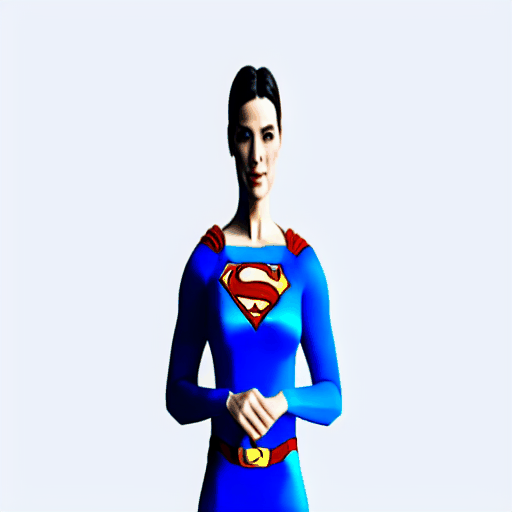

In [12]:
#@markdown Run for generating videos.

prompt = "woman in blue superman suit is talking" #@param {type:"string"}
negative_prompt = "" #@param {type:"string"}
use_inv_latent = True #@param {type:"boolean"}
inv_latent_path = "" #@param {type:"string"}
num_samples = 1 #@param {type:"number"}
guidance_scale = 12.5 #@param {type:"number"}
num_inference_steps = 50 #@param {type:"number"}
video_length = 8 #@param {type:"number"}
height = 512 #@param {type:"number"}
width = 512 #@param {type:"number"}

ddim_inv_latent = None
if use_inv_latent and inv_latent_path == "":
    from natsort import natsorted
    from glob import glob
    import os
    inv_latent_path = natsorted(glob(f"{OUTPUT_DIR}/inv_latents/*"))[-1]
    ddim_inv_latent = torch.load(inv_latent_path).to(torch.float16)
    print(f"DDIM inversion latent loaded from {inv_latent_path}")

with autocast("cuda"), torch.inference_mode():
    videos = pipe(
        prompt,
        latents=ddim_inv_latent,
        video_length=video_length,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_videos_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).videos

save_dir = "./results" #@param {type:"string"}
save_path = f"{save_dir}/{prompt}.gif"
save_videos_grid(videos, save_path)

# display
from IPython.display import Image, display
display(Image(filename=save_path))

In [28]:
#@markdown Free runtime memory
exit()